In [1]:
import os,csv,re
import pandas as pd
import numpy as np
import scanpy as sc
import math
import SpaGCN as spg
from scipy.sparse import issparse
import random, torch
import warnings
warnings.filterwarnings("ignore")
import matplotlib.colors as clr
import matplotlib.pyplot as plt
import SpaGCN as spg
#In order to read in image data, we need to install some package. Here we recommend package "opencv"
#inatll opencv in python
#!pip3 install opencv-python
import cv2
from pathlib import Path
from scanpy import read_10x_h5
import anndata

In [2]:
BASE_PATH = Path("/scratch/90days/uqxtan9/mouse_brain_coronal")

In [3]:
# adata = read_10x_h5(BASE_PATH / "V1_Adult_Mouse_Brain_filtered_feature_bc_matrix.h5")
# spatial=pd.read_csv(BASE_PATH / "spatial/tissue_positions_list.csv",sep=",",header=None,na_filter=False,index_col=0) 
# adata.obs["x1"]=spatial[1]
# adata.obs["x2"]=spatial[2]
# adata.obs["x3"]=spatial[3]
# adata.obs["x4"]=spatial[4]
# adata.obs["x5"]=spatial[5]
# #Select captured samples
# adata=adata[adata.obs["x1"]==1]
# adata.var_names=[i.upper() for i in list(adata.var_names)]
# adata.var["genename"]=adata.var.index.astype("str")
# adata.write_h5ad("./mouse_brain_10x_raw.h5ad")

In [4]:
adata=sc.read("./mouse_brain_10x_raw.h5ad")
#Read in hitology image
img=cv2.imread(str(BASE_PATH / "V1_Adult_Mouse_Brain_image.tif"))
# img=cv2.imread(str(BASE_PATH / "spatial/tissue_hires_image.png"))

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [5]:
adata.obs["x_array"]=adata.obs["x2"]
adata.obs["y_array"]=adata.obs["x3"]
adata.obs["x_pixel"]=adata.obs["x4"]
adata.obs["y_pixel"]=adata.obs["x5"]
x_array=adata.obs["x_array"].tolist()
y_array=adata.obs["y_array"].tolist()
x_pixel=adata.obs["x_pixel"].tolist()
y_pixel=adata.obs["y_pixel"].tolist()

#Test coordinates on the image
img_new=img.copy()
for i in range(len(x_pixel)):
    x=x_pixel[i]
    y=y_pixel[i]
    img_new[int(x-20):int(x+20), int(y-20):int(y+20),:]=0

cv2.imwrite('./mouse_brain_10x_raw.jpg', img_new)

True

In [6]:
s=1
b=49
adj=spg.calculate_adj_matrix(x=x_pixel,y=y_pixel, x_pixel=x_pixel, y_pixel=y_pixel, image=img, beta=b, alpha=s, histology=True)
#If histlogy image is not available, SoaGCN can calculate the adjacent matrix using the fnction below
#adj=calculate_adj_matrix(x=x_pixel,y=y_pixel, histology=False)
np.savetxt('./mouse_brain_10x_adj.csv', adj, delimiter=',')

Calculateing adj matrix using histology image...
Var of c0,c1,c2 =  12.487103939458287 106.75766298767053 43.90335715441911
Var of x,y,z =  4666037.147723295 2934587.8010952845 4666037.147723297


In [7]:
adata.var_names_make_unique()
spg.prefilter_genes(adata,min_cells=3) # avoiding all genes are zeros
spg.prefilter_specialgenes(adata)
#Normalize and take log for UMI
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)

In [8]:
p=0.5 
#Find the l value given p
l=spg.search_l(p, adj, start=0.01, end=1000, tol=0.01, max_run=100)

Run 1: l [0.01, 1000], p [0.0, 106.9199435206556]
Run 2: l [0.01, 500.005], p [0.0, 17.28647232055664]
Run 3: l [0.01, 250.0075], p [0.0, 2.399655818939209]
Run 4: l [125.00874999999999, 250.0075], p [0.2849555015563965, 2.399655818939209]
Run 5: l [125.00874999999999, 187.508125], p [0.2849555015563965, 1.0137228965759277]
Run 6: l [125.00874999999999, 156.2584375], p [0.2849555015563965, 0.5789223909378052]
Run 7: l [140.63359375, 156.2584375], p [0.4159437417984009, 0.5789223909378052]
recommended l =  148.446015625


In [9]:
#For this toy data, we set the number of clusters=7 since this tissue has 7 layers
n_clusters=19
#Set seed
r_seed=t_seed=n_seed=100
#Search for suitable resolution
res=spg.search_res(adata, adj, l, n_clusters, start=0.7, step=0.1, tol=5e-3, lr=0.05, 
                   max_epochs=20, r_seed=r_seed, t_seed=t_seed, n_seed=n_seed)

Start at res =  0.7 step =  0.1
Initializing cluster centers with louvain, resolution =  0.7
Epoch  0
Epoch  10
Res =  0.7 Num of clusters =  14
Initializing cluster centers with louvain, resolution =  0.7999999999999999
Epoch  0
Epoch  10
Res =  0.7999999999999999 Num of clusters =  17
Res changed to 0.7999999999999999
Initializing cluster centers with louvain, resolution =  0.8999999999999999
Epoch  0
Epoch  10
Res =  0.8999999999999999 Num of clusters =  18
Res changed to 0.8999999999999999
Initializing cluster centers with louvain, resolution =  0.9999999999999999
Epoch  0
Epoch  10
Res =  0.9999999999999999 Num of clusters =  18
Res changed to 0.9999999999999999
Initializing cluster centers with louvain, resolution =  1.0999999999999999
Epoch  0
Epoch  10
Res =  1.0999999999999999 Num of clusters =  18
Res changed to 1.0999999999999999
Initializing cluster centers with louvain, resolution =  1.2
Epoch  0
Epoch  10
Res =  1.2 Num of clusters =  19
recommended res =  1.2


In [10]:
clf=spg.SpaGCN()
clf.set_l(l)
#Set seed
random.seed(r_seed)
torch.manual_seed(t_seed)
np.random.seed(n_seed)
#Run
clf.train(adata,adj,init_spa=True,init="louvain",res=res, tol=5e-3, lr=0.05, max_epochs=200)
y_pred, prob=clf.predict()
adata.obs["pred"]= y_pred
adata.obs["pred"]=adata.obs["pred"].astype('category')
#Do cluster refinement(optional)
#shape="hexagon" for Visium data, "square" for ST data.
adj_2d=spg.calculate_adj_matrix(x=x_array,y=y_array, histology=False)
refined_pred=spg.refine(sample_id=adata.obs.index.tolist(), pred=adata.obs["pred"].tolist(), dis=adj_2d, shape="hexagon")
adata.obs["refined_pred"]=refined_pred
adata.obs["refined_pred"]=adata.obs["refined_pred"].astype('category')
#Save results
# adata.write_h5ad("./mouse_brain_10x_results.h5ad")

Initializing cluster centers with louvain, resolution =  1.2
Epoch  0
Epoch  10
Epoch  20
Epoch  30
delta_label  0.004818383988139363 < tol  0.005
Reach tolerance threshold. Stopping training.
Total epoch: 37
Calculateing adj matrix using xy only...


In [14]:
adata = anndata.read_h5ad("./mouse_brain_10x_results.h5ad")

In [16]:
adata.obs.to_csv("mouse_brain_10x_results_obs.csv")

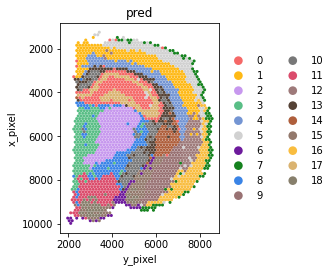

In [11]:
plot_color=["#F56867","#FEB915","#C798EE","#59BE86","#7495D3","#D1D1D1","#6D1A9C","#15821E","#3A84E6","#997273","#787878","#DB4C6C","#9E7A7A","#554236","#AF5F3C","#93796C","#F9BD3F","#DAB370","#877F6C","#268785"]
#Plot spatial domains
domains="pred"
num_celltype=len(adata.obs[domains].unique())
adata.uns[domains+"_colors"]=list(plot_color[:num_celltype])
ax=sc.pl.scatter(adata,alpha=1,x="y_pixel",y="x_pixel",color=domains,title=domains,color_map=plot_color,show=False,size=100000/adata.shape[0])
ax.set_aspect('equal', 'box')
ax.axes.invert_yaxis()
# plt.savefig("./mouse_brain_10x/pred.png", dpi=600)
# plt.close()
plt.show()

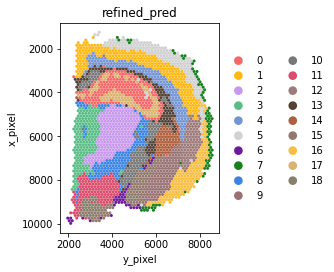

In [12]:
#Plot refined spatial domains
domains="refined_pred"
num_celltype=len(adata.obs[domains].unique())
adata.uns[domains+"_colors"]=list(plot_color[:num_celltype])
ax=sc.pl.scatter(adata,alpha=1,x="y_pixel",y="x_pixel",color=domains,title=domains,color_map=plot_color,show=False,size=100000/adata.shape[0])
ax.set_aspect('equal', 'box')
ax.axes.invert_yaxis()
# plt.savefig("./mouse_brain_10x/refined_pred.png", dpi=600)
# plt.close()
plt.show()

In [5]:
adata=sc.read("./mouse_brain_10x_raw.h5ad")
#Read in hitology image
img=cv2.imread(str(BASE_PATH / "V1_Adult_Mouse_Brain_image.tif"))

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [81]:
sample_cell= 0.2
sample_gene=0.1

In [82]:
    n_cells = adata.X.shape[0]
    n_genes = adata.X.shape[1]
    indices_cells = np.random.choice(np.arange(n_cells), replace=False,
                           size=int(n_cells * sample_cell))
    indices_genes = np.random.choice(np.arange(n_genes), replace=False,
                           size=int(n_genes * (1-sample_gene)))
    test = adata.X.toarray()
    mask = np.zeros(test.shape)
    mask[indices_cells] = 1
    mask[:, indices_genes] = 0
    mask = mask.astype(bool)
    test[mask] = 0
    
    adata_noise = adata.copy()
    adata_noise.X = test

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [83]:
adata = adata_noise.copy()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [84]:
adata.obs["x_array"]=adata.obs["x2"]
adata.obs["y_array"]=adata.obs["x3"]
adata.obs["x_pixel"]=adata.obs["x4"]
adata.obs["y_pixel"]=adata.obs["x5"]
x_array=adata.obs["x_array"].tolist()
y_array=adata.obs["y_array"].tolist()
x_pixel=adata.obs["x_pixel"].tolist()
y_pixel=adata.obs["y_pixel"].tolist()

#Test coordinates on the image
img_new=img.copy()
for i in range(len(x_pixel)):
    x=x_pixel[i]
    y=y_pixel[i]
    img_new[int(x-20):int(x+20), int(y-20):int(y+20),:]=0

cv2.imwrite('./mouse_brain_10x_noise.jpg', img_new)

True

In [85]:
s=1
b=49
adj=spg.calculate_adj_matrix(x=x_pixel,y=y_pixel, x_pixel=x_pixel, y_pixel=y_pixel, image=img, beta=b, alpha=s, histology=True)
#If histlogy image is not available, SoaGCN can calculate the adjacent matrix using the fnction below
#adj=calculate_adj_matrix(x=x_pixel,y=y_pixel, histology=False)
np.savetxt('./mouse_brain_10x_adj_noise.csv', adj, delimiter=',')

Calculateing adj matrix using histology image...
Var of c0,c1,c2 =  12.487103939458287 106.75766298767053 43.90335715441911
Var of x,y,z =  4666037.147723295 2934587.8010952845 4666037.147723297


In [86]:
adata.var_names_make_unique()
spg.prefilter_genes(adata,min_cells=3) # avoiding all genes are zeros
spg.prefilter_specialgenes(adata)
#Normalize and take log for UMI
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)

In [87]:
p=0.5 
#Find the l value given p
l=spg.search_l(p, adj, start=0.01, end=1000, tol=0.01, max_run=100)

Run 1: l [0.01, 1000], p [0.0, 106.9199435206556]
Run 2: l [0.01, 500.005], p [0.0, 17.28647232055664]
Run 3: l [0.01, 250.0075], p [0.0, 2.399655818939209]
Run 4: l [125.00874999999999, 250.0075], p [0.2849555015563965, 2.399655818939209]
Run 5: l [125.00874999999999, 187.508125], p [0.2849555015563965, 1.0137228965759277]
Run 6: l [125.00874999999999, 156.2584375], p [0.2849555015563965, 0.5789223909378052]
Run 7: l [140.63359375, 156.2584375], p [0.4159437417984009, 0.5789223909378052]
recommended l =  148.446015625


In [88]:
#For this toy data, we set the number of clusters=7 since this tissue has 7 layers
n_clusters=19
#Set seed
r_seed=t_seed=n_seed=100
#Search for suitable resolution
res=spg.search_res(adata, adj, l, n_clusters, start=0.7, step=0.1, tol=5e-3, lr=0.05, 
                   max_epochs=20, r_seed=r_seed, t_seed=t_seed, n_seed=n_seed)

Start at res =  0.7 step =  0.1
Initializing cluster centers with louvain, resolution =  0.7
Epoch  0
Epoch  10
Res =  0.7 Num of clusters =  12
Initializing cluster centers with louvain, resolution =  0.7999999999999999
Epoch  0
Epoch  10
Res =  0.7999999999999999 Num of clusters =  14
Res changed to 0.7999999999999999
Initializing cluster centers with louvain, resolution =  0.8999999999999999
Epoch  0
Epoch  10
Res =  0.8999999999999999 Num of clusters =  18
Res changed to 0.8999999999999999
Initializing cluster centers with louvain, resolution =  0.9999999999999999
Epoch  0
Epoch  10
Res =  0.9999999999999999 Num of clusters =  20
Step changed to 0.05
Initializing cluster centers with louvain, resolution =  0.95
Epoch  0
Epoch  10
Res =  0.95 Num of clusters =  19
recommended res =  0.95


In [89]:
clf=spg.SpaGCN()
clf.set_l(l)
#Set seed
random.seed(r_seed)
torch.manual_seed(t_seed)
np.random.seed(n_seed)
#Run
clf.train(adata,adj,init_spa=True,init="louvain",res=res, tol=5e-3, lr=0.05, max_epochs=200)
y_pred, prob=clf.predict()
adata.obs["pred"]= y_pred
adata.obs["pred"]=adata.obs["pred"].astype('category')
#Do cluster refinement(optional)
#shape="hexagon" for Visium data, "square" for ST data.
adj_2d=spg.calculate_adj_matrix(x=x_array,y=y_array, histology=False)
refined_pred=spg.refine(sample_id=adata.obs.index.tolist(), pred=adata.obs["pred"].tolist(), dis=adj_2d, shape="hexagon")
adata.obs["refined_pred"]=refined_pred
adata.obs["refined_pred"]=adata.obs["refined_pred"].astype('category')
#Save results
adata.write_h5ad("./mouse_brain_10x_results_noise.h5ad")

Initializing cluster centers with louvain, resolution =  0.95
Epoch  0
Epoch  10
Epoch  20
Epoch  30
delta_label  0.004818383988139363 < tol  0.005
Reach tolerance threshold. Stopping training.
Total epoch: 34
Calculateing adj matrix using xy only...


In [92]:
plot_color=["#F56867","#FEB915","#C798EE","#59BE86","#7495D3","#D1D1D1","#6D1A9C","#15821E","#3A84E6","#997273","#787878","#DB4C6C","#9E7A7A","#554236","#AF5F3C","#93796C","#F9BD3F","#DAB370","#877F6C","#268785"]
#Plot spatial domains
domains="pred"
num_celltype=len(adata.obs[domains].unique())
adata.uns[domains+"_colors"]=list(plot_color[:num_celltype])
ax=sc.pl.scatter(adata,alpha=1,x="y_pixel",y="x_pixel",color=domains,title=domains,color_map=plot_color,show=False,size=100000/adata.shape[0])
ax.set_aspect('equal', 'box')
ax.axes.invert_yaxis()
plt.savefig("./mouse_brain_10x/pred_noise.png", dpi=600)
plt.close()
plt.show()

In [93]:
#Plot refined spatial domains
domains="refined_pred"
num_celltype=len(adata.obs[domains].unique())
adata.uns[domains+"_colors"]=list(plot_color[:num_celltype])
ax=sc.pl.scatter(adata,alpha=1,x="y_pixel",y="x_pixel",color=domains,title=domains,color_map=plot_color,show=False,size=100000/adata.shape[0])
ax.set_aspect('equal', 'box')
ax.axes.invert_yaxis()
plt.savefig("./mouse_brain_10x/refined_pred_noise.png", dpi=600)
plt.close()
# plt.show()

In [2]:
BASE_PATH = Path("/home/uqxtan9/90days/Human_Brain_spatialLIBD/151507")
adata = read_10x_h5(BASE_PATH / "151507_filtered_feature_bc_matrix.h5")
spatial=pd.read_csv(BASE_PATH / "spatial/tissue_positions_list.txt",sep=",",header=None,na_filter=False,index_col=0) 
adata.obs["x1"]=spatial[1]
adata.obs["x2"]=spatial[2]
adata.obs["x3"]=spatial[3]
adata.obs["x4"]=spatial[4]
adata.obs["x5"]=spatial[5]
#Select captured samples
adata=adata[adata.obs["x1"]==1]
adata.var_names=[i.upper() for i in list(adata.var_names)]
adata.var["genename"]=adata.var.index.astype("str")
adata.write_h5ad("./151507.h5ad")

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'genename' as categorical


In [3]:
img=cv2.imread(str(BASE_PATH / "151507_full_image.tif"))

In [4]:
adata.obs["x_array"]=adata.obs["x2"]
adata.obs["y_array"]=adata.obs["x3"]
adata.obs["x_pixel"]=adata.obs["x4"]
adata.obs["y_pixel"]=adata.obs["x5"]
x_array=adata.obs["x_array"].tolist()
y_array=adata.obs["y_array"].tolist()
x_pixel=adata.obs["x_pixel"].tolist()
y_pixel=adata.obs["y_pixel"].tolist()

#Test coordinates on the image
img_new=img.copy()
for i in range(len(x_pixel)):
    x=x_pixel[i]
    y=y_pixel[i]
    img_new[int(x-20):int(x+20), int(y-20):int(y+20),:]=0

cv2.imwrite('./151507_full_image.jpg', img_new)

True

In [5]:
s=1
b=49
adj=spg.calculate_adj_matrix(x=x_pixel,y=y_pixel, x_pixel=x_pixel, y_pixel=y_pixel, image=img, beta=b, alpha=s, histology=True)
#If histlogy image is not available, SoaGCN can calculate the adjacent matrix using the fnction below
#adj=calculate_adj_matrix(x=x_pixel,y=y_pixel, histology=False)
np.savetxt('./151507_adj.csv', adj, delimiter=',')

Calculateing adj matrix using histology image...
Var of c0,c1,c2 =  29.477233022425033 134.30750047472108 40.144995243818755
Var of x,y,z =  6252621.155503006 5320894.161992535 6252621.155503008


In [6]:
adata.var_names_make_unique()
spg.prefilter_genes(adata,min_cells=3) # avoiding all genes are zeros
spg.prefilter_specialgenes(adata)
#Normalize and take log for UMI
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)

In [7]:
p=0.5 
#Find the l value given p
l=spg.search_l(p, adj, start=0.01, end=1000, tol=0.01, max_run=100)

Run 1: l [0.01, 1000], p [0.0, 148.15217311031813]
Run 2: l [0.01, 500.005], p [0.0, 25.904523849487305]
Run 3: l [0.01, 250.0075], p [0.0, 3.798725128173828]
Run 4: l [125.00874999999999, 250.0075], p [0.4550950527191162, 3.798725128173828]
Run 5: l [125.00874999999999, 187.508125], p [0.4550950527191162, 1.628591537475586]
Run 6: l [125.00874999999999, 156.2584375], p [0.4550950527191162, 0.9323179721832275]
Run 7: l [125.00874999999999, 140.63359375], p [0.4550950527191162, 0.6683287620544434]
Run 8: l [125.00874999999999, 132.821171875], p [0.4550950527191162, 0.5556210279464722]
recommended l =  128.91496093749998


In [8]:
#For this toy data, we set the number of clusters=7 since this tissue has 7 layers
n_clusters=7
#Set seed
r_seed=t_seed=n_seed=100
#Search for suitable resolution
res=spg.search_res(adata, adj, l, n_clusters, start=0.7, step=0.1, tol=5e-3, lr=0.05, 
                   max_epochs=20, r_seed=r_seed, t_seed=t_seed, n_seed=n_seed)

Start at res =  0.7 step =  0.1
Initializing cluster centers with louvain, resolution =  0.7
Epoch  0
Epoch  10
Res =  0.7 Num of clusters =  6
Initializing cluster centers with louvain, resolution =  0.7999999999999999
Epoch  0
Epoch  10
Res =  0.7999999999999999 Num of clusters =  7
recommended res =  0.7999999999999999


In [9]:
clf=spg.SpaGCN()
clf.set_l(l)
#Set seed
random.seed(r_seed)
torch.manual_seed(t_seed)
np.random.seed(n_seed)
#Run
clf.train(adata,adj,init_spa=True,init="louvain",res=res, tol=5e-3, lr=0.05, max_epochs=200)
y_pred, prob=clf.predict()
adata.obs["pred"]= y_pred
adata.obs["pred"]=adata.obs["pred"].astype('category')
#Do cluster refinement(optional)
#shape="hexagon" for Visium data, "square" for ST data.
adj_2d=spg.calculate_adj_matrix(x=x_array,y=y_array, histology=False)
refined_pred=spg.refine(sample_id=adata.obs.index.tolist(), pred=adata.obs["pred"].tolist(), dis=adj_2d, shape="hexagon")
adata.obs["refined_pred"]=refined_pred
adata.obs["refined_pred"]=adata.obs["refined_pred"].astype('category')
#Save results
adata.write_h5ad("./151507_results.h5ad")

Initializing cluster centers with louvain, resolution =  0.7999999999999999
Epoch  0
Epoch  10
Epoch  20
Epoch  30
Epoch  40
Epoch  50
Epoch  60
delta_label  0.0044959772834831995 < tol  0.005
Reach tolerance threshold. Stopping training.
Total epoch: 64
Calculateing adj matrix using xy only...


In [12]:
plot_color=["#F56867","#FEB915","#C798EE","#59BE86","#7495D3","#D1D1D1","#6D1A9C","#15821E","#3A84E6","#997273","#787878","#DB4C6C","#9E7A7A","#554236","#AF5F3C","#93796C","#F9BD3F","#DAB370","#877F6C","#268785"]
#Plot spatial domains
domains="pred"
num_celltype=len(adata.obs[domains].unique())
adata.uns[domains+"_colors"]=list(plot_color[:num_celltype])
ax=sc.pl.scatter(adata,alpha=1,x="y_pixel",y="x_pixel",color=domains,title=domains,color_map=plot_color,show=False,size=100000/adata.shape[0])
ax.set_aspect('equal', 'box')
ax.axes.invert_yaxis()
plt.savefig("./151507/pred.png", dpi=600)
plt.close()
plt.show()

In [13]:
#Plot refined spatial domains
domains="refined_pred"
num_celltype=len(adata.obs[domains].unique())
adata.uns[domains+"_colors"]=list(plot_color[:num_celltype])
ax=sc.pl.scatter(adata,alpha=1,x="y_pixel",y="x_pixel",color=domains,title=domains,color_map=plot_color,show=False,size=100000/adata.shape[0])
ax.set_aspect('equal', 'box')
ax.axes.invert_yaxis()
plt.savefig("./151507/refined_pred.png", dpi=600)
plt.close()
plt.show()